# Lab 04 : Test set evaluation -- exercise

In [6]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_name = 'test_set_exercise.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import utils

### Download the CIFAR dataset -- check the size carefully!

In [8]:
from utils import check_cifar_dataset_exists
data_path=check_cifar_dataset_exists()

train_data=torch.load(data_path+'cifar/train_data.pt')
train_label=torch.load(data_path+'cifar/train_label.pt')
test_data=torch.load(data_path+'cifar/test_data.pt')
test_label=torch.load(data_path+'cifar/test_label.pt')

print(train_data.size())

torch.Size([50000, 3, 32, 32])


### Make a ONE layer net class. 

In [9]:
class one_layer_net(nn.Module):

    def __init__(self, input_size, output_size):
        super(one_layer_net , self).__init__()
        self.linear_layer = nn.Linear( input_size, output_size , bias=True)
        
    def forward(self, x):
        scores = self.linear_layer(x)
        return scores

### Build the net. 

In [10]:
net=one_layer_net(3072,10)
print(net)

one_layer_net(
  (linear_layer): Linear(in_features=3072, out_features=10, bias=True)
)


### Choose the criterion and optimizer. Also choose:


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD( net.parameters() , lr=0.01 )
bs=20

### Do 50 passes through the training set.

In [12]:
for epoch in range(50):
    
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(50000)
 
    for count in range(0,50000,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label= train_label[indices]

        # reshape the minibatch
        inputs = minibatch_data.view(bs,3072)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        
        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    
    print('epoch=',epoch, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        
    

epoch= 0 	 loss= 1.958435620880127 	 error= 69.54999997615813 percent
epoch= 1 	 loss= 1.8625017852306367 	 error= 65.15199998378753 percent
epoch= 2 	 loss= 1.835319188261032 	 error= 64.20200001001358 percent
epoch= 3 	 loss= 1.8133225433826448 	 error= 63.197999975681306 percent
epoch= 4 	 loss= 1.8048487916469573 	 error= 62.77399996995926 percent
epoch= 5 	 loss= 1.7970082124233246 	 error= 62.380000002384186 percent
epoch= 6 	 loss= 1.7907178359508515 	 error= 62.35199995994568 percent
epoch= 7 	 loss= 1.782043169593811 	 error= 61.646000008583066 percent
epoch= 8 	 loss= 1.7763303175926208 	 error= 61.389999957084655 percent
epoch= 9 	 loss= 1.7740949018478394 	 error= 61.303999979496005 percent
epoch= 10 	 loss= 1.7687824460029602 	 error= 61.20600000143052 percent
epoch= 11 	 loss= 1.7653595728874207 	 error= 61.15600001811982 percent
epoch= 12 	 loss= 1.765675163078308 	 error= 61.24200002670288 percent
epoch= 13 	 loss= 1.7585349222898483 	 error= 60.76199996948242 percent
e

# You only have to complete this cell

### So we are doing around 59% error on the training set. BUT how much are we doing on test set?

In [16]:
running_error= 0
num_batches= 0

for count in range(0, 10000, bs):

    # extract the minibatch
    minibatch_data =  test_data[count:count+bs]
    minibatch_label=  test_label[count:count+bs]

    # reshape the minibatch
    inputs = minibatch_data.view(bs, 3072)
    
    # feed it to the network
    scores = net(inputs)

    # compute the error made on this batch
    error = utils.get_error(scores, minibatch_label)
    
    # add it to the running error
    running_error += error.item()

    num_batches += 1


# compute error rate on the full test set
total_error = running_error / num_batches

print( 'error rate on test set =', total_error*100 ,'percent')

error rate on test set = 62.20999991893768 percent


### Choose image at random from the test set and see how good/bad are the predictions

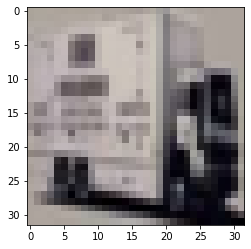

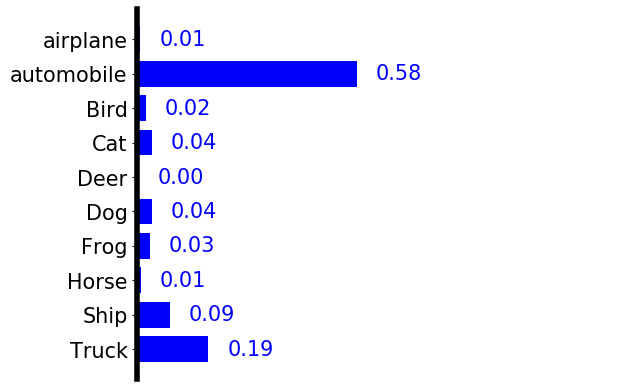

In [15]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
utils.show(im)

# feed it to the net and display the confidence scores
scores =  net( im.view(1,3072)) 
probs= F.softmax(scores, dim=1)
utils.show_prob_cifar(probs)